# Monitoring & Safeguards for Recommenders

Covers:
- Feature + target drift
- Segment health
- Ranking quality metrics: NDCG/MRR
- Online monitoring primitives: time-series + alerts
- Safeguards: policy checks, safety filters, controlled fallback behavior


## 0) Setup


In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import default_rng

rng = default_rng(11)

def l2_normalize(x, axis=-1, eps=1e-12):
    n = np.linalg.norm(x, axis=axis, keepdims=True)
    return x / np.maximum(n, eps)

def ndcg_at_k(relevances, k=10):
    rel = np.asarray(relevances)[:k]
    if rel.size == 0:
        return 0.0
    discounts = 1.0 / np.log2(np.arange(2, rel.size + 2))
    dcg = (rel * discounts).sum()
    ideal = np.sort(rel)[::-1]
    idcg = (ideal * discounts).sum()
    return float(dcg / idcg) if idcg > 0 else 0.0

def mrr_at_k(relevances, k=10):
    rel = np.asarray(relevances)[:k]
    hits = np.where(rel > 0)[0]
    return float(1.0 / (hits[0] + 1.0)) if hits.size else 0.0

def psi(expected, actual, bins=10, eps=1e-6):
    expected = np.asarray(expected)
    actual = np.asarray(actual)
    qs = np.quantile(expected, np.linspace(0, 1, bins + 1))
    qs = np.unique(qs)
    if qs.size < 3:
        return 0.0
    e_counts, _ = np.histogram(expected, bins=qs)
    a_counts, _ = np.histogram(actual, bins=qs)
    e = e_counts / max(1, e_counts.sum())
    a = a_counts / max(1, a_counts.sum())
    e = np.clip(e, eps, 1.0)
    a = np.clip(a, eps, 1.0)
    return float(np.sum((a - e) * np.log(a / e)))

def zscore_anomaly(x, window=14, z=4.0):
    x = np.asarray(x, dtype=float)
    flags = np.zeros_like(x, dtype=bool)
    for i in range(window, len(x)):
        mu = x[i-window:i].mean()
        sd = x[i-window:i].std() + 1e-9
        flags[i] = abs((x[i] - mu) / sd) > z
    return flags


## 1) Simulate production logs: requests, rankings, clicks, latency


In [2]:
n_users = 12000
n_items = 4000
d = 24

U = l2_normalize(rng.normal(size=(n_users, d)).astype(np.float32))
V = l2_normalize(rng.normal(size=(n_items, d)).astype(np.float32))
pop = rng.power(a=2.0, size=n_items).astype(np.float32)

regions = np.array(["NA", "EU", "APAC"])
devices = np.array(["mobile", "desktop"])
tenures = np.array(["new", "returning"])

cats = np.array(["office", "gaming", "fitness", "kitchen", "air", "travel"])
item_cat = rng.choice(cats, size=n_items, replace=True, p=np.array([.22,.16,.16,.18,.14,.14]))
item_text = np.array([f"{c} item {i}" for i, c in enumerate(item_cat)])

blocked_cats = set(["travel"])  # policy
unsafe_pattern = re.compile(r"\bweapon|hate|adult\b", re.IGNORECASE)

def baseline_rank(user_id, k=20):
    u = U[user_id]
    s = (V @ u) + 0.15 * pop
    idx = np.argpartition(s, -k)[-k:]
    idx = idx[np.argsort(s[idx])[::-1]]
    return idx, s[idx]

def click_model(user_id, item_id, day, region, device, tenure):
    base = float((U[user_id] @ V[item_id]))
    p = 0.08 + 0.12 * (base > 0.25) + 0.05 * float(pop[item_id] > np.quantile(pop, 0.9))
    if device == "mobile":
        p *= 0.92
    if tenure == "new":
        p *= 0.85
    if region == "EU":
        p *= 0.95
    # Drift: after day 35, gaming items underperform (misalignment/feedback)
    if day >= 35 and item_cat[item_id] == "gaming":
        p *= 0.65
    return float(np.clip(p, 0.001, 0.8))

def simulate(days=60, reqs_per_day=900, k=20):
    rows = []
    for day in range(days):
        for _ in range(reqs_per_day):
            user_id = int(rng.integers(0, n_users))
            region = str(rng.choice(regions, p=[0.55, 0.3, 0.15]))
            device = str(rng.choice(devices, p=[0.62, 0.38]))
            tenure = str(rng.choice(tenures, p=[0.28, 0.72]))

            # Traffic drift: after day 40, more mobile + more new users
            if day >= 40:
                device = "mobile" if rng.random() < 0.76 else "desktop"
                tenure = "new" if rng.random() < 0.38 else "returning"

            item_ids, scores = baseline_rank(user_id, k=k)

            # Guardrails: policy + safety filters
            keep = []
            for iid in item_ids:
                if item_cat[iid] in blocked_cats:
                    continue
                if unsafe_pattern.search(item_text[iid] or ""):
                    continue
                keep.append(iid)
            keep = np.array(keep, dtype=int)

            # Controlled fallback if candidate set collapses
            if keep.size < 10:
                fallback = np.argsort(pop)[::-1]
                safe = []
                for iid in fallback:
                    if item_cat[iid] in blocked_cats:
                        continue
                    if unsafe_pattern.search(item_text[iid] or ""):
                        continue
                    safe.append(iid)
                    if len(safe) >= k:
                        break
                keep = np.array(safe, dtype=int)

            clicked = 0
            rels = []
            for rank, iid in enumerate(keep[:k]):
                p = click_model(user_id, int(iid), day, region, device, tenure)
                rels.append(1.0 if p > 0.12 else 0.0)
                if rank == 0 and rng.random() < p:
                    clicked = 1

            base_ms = 35 + rng.normal(0, 5)
            spike = rng.uniform(80, 220) if rng.random() < 0.01 else 0.0
            latency_ms = float(max(5.0, base_ms + spike))

            rows.append({
                "day": day,
                "user_id": user_id,
                "region": region,
                "device": device,
                "tenure": tenure,
                "latency_ms": latency_ms,
                "clicked_top1": clicked,
                "ndcg@10": ndcg_at_k(rels, k=10),
                "mrr@10": mrr_at_k(rels, k=10),
                "top1_cat": str(item_cat[int(keep[0])]),
            })
    return pd.DataFrame(rows)

logs = simulate()
logs.head()


,day,user_id,region,device,tenure,latency_ms,clicked_top1,ndcg@10,mrr@10,top1_cat
0,0,2455,EU,mobile,new,35.295554,1,1.0,1.0,gaming
1,0,4441,NA,mobile,new,44.840547,0,1.0,1.0,air
2,0,2617,EU,mobile,returning,38.980623,0,1.0,1.0,air
3,0,10183,EU,mobile,returning,36.339657,0,1.0,1.0,fitness
4,0,3368,EU,mobile,returning,46.641289,0,1.0,1.0,air


## 2) Core dashboards: overall health + latency + ranking quality


In [3]:
daily = logs.groupby("day").agg(
    ctr_top1=("clicked_top1","mean"),
    ndcg10=("ndcg@10","mean"),
    mrr10=("mrr@10","mean"),
    p95_latency=("latency_ms", lambda x: np.quantile(x, 0.95)),
    p99_latency=("latency_ms", lambda x: np.quantile(x, 0.99)),
    mobile_share=("device", lambda x: np.mean(x=="mobile")),
    new_share=("tenure", lambda x: np.mean(x=="new")),
    gaming_top1_share=("top1_cat", lambda x: np.mean(x=="gaming")),
).reset_index()

daily.tail()


,day,ctr_top1,ndcg10,mrr10,p95_latency,p99_latency,mobile_share,new_share,gaming_top1_share
55,55,0.215556,0.952397,0.938519,43.441997,48.006606,0.741111,0.387778,0.181111
56,56,0.172222,0.956210,0.951204,43.399041,151.659808,0.742222,0.366667,0.170000
57,57,0.165556,0.946030,0.927963,43.198014,52.832891,0.772222,0.397778,0.203333
58,58,0.165556,0.949807,0.934852,43.701527,50.323779,0.747778,0.402222,0.180000
59,59,0.150000,0.947439,0.936667,44.423503,174.506157,0.775556,0.395556,0.181111


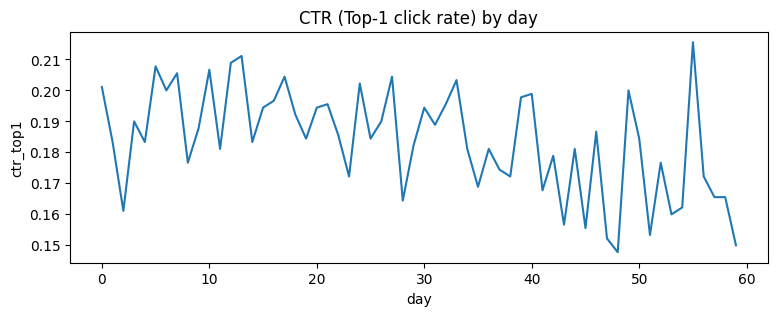

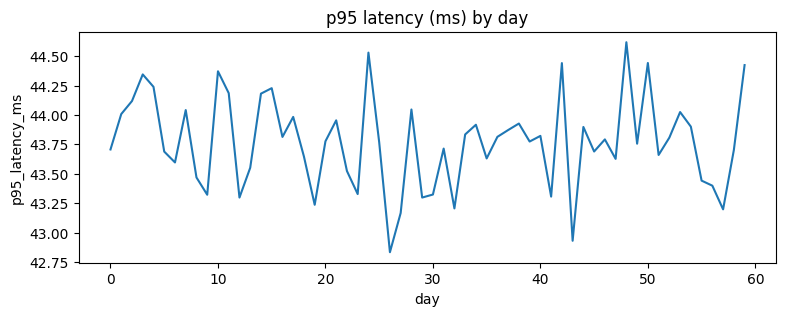

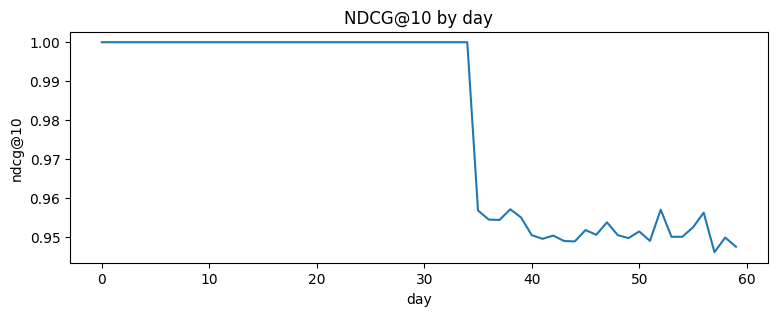

In [4]:
plt.figure(figsize=(9,3))
plt.plot(daily["day"], daily["ctr_top1"])
plt.title("CTR (Top-1 click rate) by day")
plt.xlabel("day"); plt.ylabel("ctr_top1"); plt.show()

plt.figure(figsize=(9,3))
plt.plot(daily["day"], daily["p95_latency"])
plt.title("p95 latency (ms) by day")
plt.xlabel("day"); plt.ylabel("p95_latency_ms"); plt.show()

plt.figure(figsize=(9,3))
plt.plot(daily["day"], daily["ndcg10"])
plt.title("NDCG@10 by day")
plt.xlabel("day"); plt.ylabel("ndcg@10"); plt.show()


## 3) Segment health: find where things are breaking


In [5]:
seg = logs.groupby(["day","region","device","tenure"]).agg(
    ctr=("clicked_top1","mean"),
    ndcg10=("ndcg@10","mean"),
    n=("clicked_top1","size"),
    p95_latency=("latency_ms", lambda x: np.quantile(x, 0.95)),
).reset_index()

seg = seg[seg["n"] >= 200]
last = seg[seg["day"] >= seg["day"].max()-6].copy()
last.sort_values(["ctr","ndcg10"]).head(12)


,day,region,device,tenure,ctr,ndcg10,n,p95_latency
659,54,NA,mobile,returning,0.149780,0.946556,227,42.737205
719,59,NA,mobile,returning,0.152174,0.938047,230,44.527556
647,53,NA,mobile,returning,0.161943,0.942037,247,43.960475
683,56,NA,mobile,returning,0.171053,0.942001,228,43.173356
695,57,NA,mobile,returning,0.183036,0.937019,224,43.217714
707,58,NA,mobile,returning,0.187500,0.938982,208,42.352754
671,55,NA,mobile,returning,0.206751,0.940479,237,42.709673


## 4) Drift: features and targets


In [6]:
pre = logs[logs["day"] < 35]
post = logs[logs["day"] >= 45]

psi_latency = psi(pre["latency_ms"], post["latency_ms"], bins=12)
psi_mobile = psi((pre["device"]=="mobile").astype(int), (post["device"]=="mobile").astype(int), bins=4)
psi_new = psi((pre["tenure"]=="new").astype(int), (post["tenure"]=="new").astype(int), bins=4)

pd.Series({"PSI_latency": psi_latency, "PSI_mobile_share": psi_mobile, "PSI_new_share": psi_new})


,0
PSI_latency,0.000539
PSI_mobile_share,0.000000
PSI_new_share,0.000000


PSI rough reading (rule-of-thumb):
- `< 0.1`: small shift
- `0.1–0.25`: moderate shift (investigate)
- `> 0.25`: large shift (assume behavior changed)


In [7]:
pre_ctr = daily[daily["day"] < 35]["ctr_top1"].mean()
post_ctr = daily[daily["day"] >= 35]["ctr_top1"].mean()

pd.Series({
    "ctr_pre_mean": pre_ctr,
    "ctr_post_mean": post_ctr,
    "gaming_exposure_post_mean": daily[daily["day"]>=35]["gaming_top1_share"].mean(),
})


,0
ctr_pre_mean,0.191397
ctr_post_mean,0.173022
gaming_exposure_post_mean,0.181911


## 5) Alerting: anomaly flags on time series


In [8]:
flags_ctr = zscore_anomaly(daily["ctr_top1"].values, window=14, z=4.0)
flags_ndcg = zscore_anomaly(daily["ndcg10"].values, window=14, z=4.0)
flags_p95 = zscore_anomaly(daily["p95_latency"].values, window=14, z=4.0)

alerts = daily.copy()
alerts["alert_ctr"] = flags_ctr
alerts["alert_ndcg"] = flags_ndcg
alerts["alert_p95_latency"] = flags_p95

alerts[alerts[["alert_ctr","alert_ndcg","alert_p95_latency"]].any(axis=1)]


,day,ctr_top1,ndcg10,mrr10,p95_latency,p99_latency,mobile_share,new_share,gaming_top1_share,alert_ctr,alert_ndcg,alert_p95_latency
35,35,0.168889,0.95675,0.94837,43.630398,49.565817,0.622222,0.264444,0.166667,False,True,False


## 6) Safeguards: policy filters + safety filters + controlled fallback


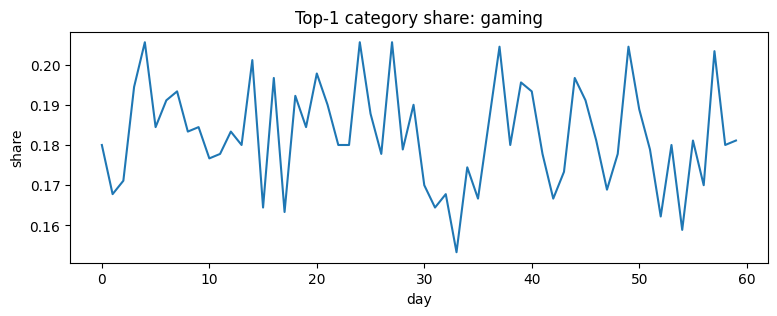

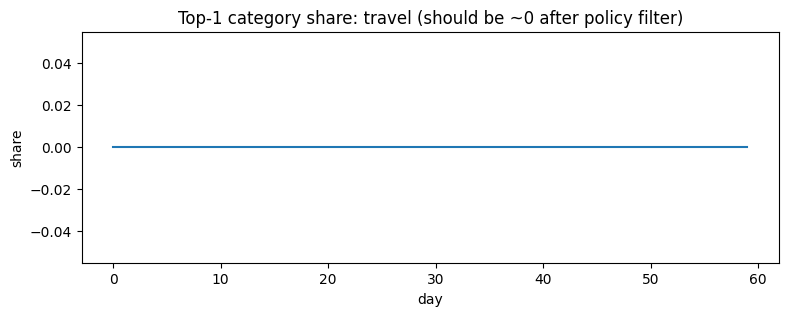

In [10]:
top1_counts = logs.groupby("day")["top1_cat"].value_counts(normalize=True).unstack(fill_value=0.0).reset_index()

plt.figure(figsize=(9,3))
plt.plot(top1_counts["day"], top1_counts.get("gaming", 0.0))
plt.title("Top-1 category share: gaming")
plt.xlabel("day"); plt.ylabel("share"); plt.show()

plt.figure(figsize=(9,3))
travel_data = top1_counts["travel"] if "travel" in top1_counts.columns else pd.Series(0.0, index=top1_counts.index)
plt.plot(top1_counts["day"], travel_data)
plt.title("Top-1 category share: travel (should be ~0 after policy filter)")
plt.xlabel("day"); plt.ylabel("share"); plt.show()

## 7) Incident triage checklist


When CTR/NDCG drops or latency spikes:

1. **Confirm scope**
   - global vs segment (region/device/tenure)
   - surface-specific (home feed vs search vs notifications)

2. **Check invariants**
   - traffic mix, request volume
   - candidate-set size after filters (policy/safety)
   - error rates: timeouts, cache stampedes, downstream failures

3. **Localize**
   - PSI on key features (traffic and scoring inputs)
   - exposure shifts (category share, popularity bias)
   - deploys/backfills/schema changes

4. **Mitigate**
   - disable expensive steps (reranker), tighten budgets
   - reduce rerank top_m, reduce candidate K
   - degrade safely: popularity baseline with filters, or rollback to known-good snapshot

5. **After**
   - add missing metrics (filter drop rate, candidate collapse rate)
   - canary + automated rollback on large regressions
